# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Create Final Maps and Figures

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



![data-description](images/data-description.png)

Screenshot of data description.  
Source: https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Extreme-Flood-with-2080-S/w8eg-8ha6

![iem-cover-photo](images/flood-scenarios.png)
  
Screen shot of flood scenarios for the NYC Stormwater Flood Maps.    
Source: https://experience.arcgis.com/experience/6f4cc60710dc433585790cd2b4b5dd0e

# Stormwater Flood Map Layer and Geographic Boundaries

## Stormwater Flood Map Layer

In [3]:
# read in data
gdf = gpd.read_file('data/stormwater-data.zip')

# sanity checks
print('shape of data: {}'.format(gdf.shape))
print('crs: {}'.format(gdf.crs))

# preview data
gdf.head()

shape of data: (12036, 5)
crs: epsg:2263


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


## NYC Boroughs

In [4]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)
borough_gdf = borough_gdf.to_crs(2263)

# preview data
print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((1032452.015 154469.237, 103245..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((1022227.320 152028.146, 102207..."


## Neigborhood Tabulation Area (NTA)

In [5]:
# importing neighborhood boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
nta_gdf = gpd.read_file(path)
nta_gdf = nta_gdf.to_crs(2263)

# preview data
print('shape of data: {}'.format(nta_gdf.shape))
nta_gdf.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23..."
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21..."
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19..."
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436..."
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ..."


I like having the borough boundaries as general map boundaries for New York City. However, I like calculating statistics at the Neighborhood Tabulation Area (NTA) level. 

# Exploratory Stormwater Flood Maps

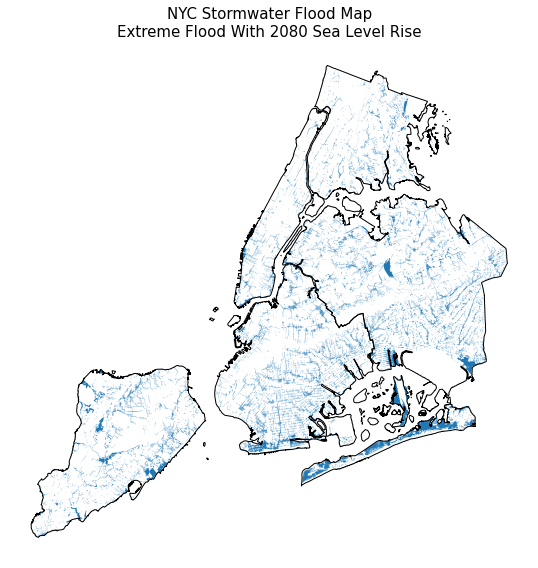

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax=ax)

borough_gdf.plot(
    ax=ax,
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.title('NYC Stormwater Flood Map\nExtreme Flood With 2080 Sea Level Rise', fontsize=15)
plt.axis('off')
plt.tight_layout()

**Figure xx**: NYC Stormwater Flood Map Extreme Flood With 2080 Sea Level Rise.

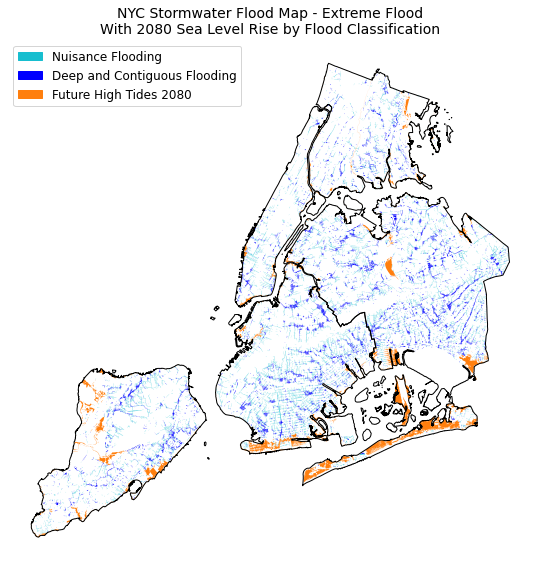

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

patches = []
colors = ['tab:cyan', 'blue', 'tab:orange']
classifications = gdf['flood_classification'].unique()

for label, color in zip(classifications, colors):
    
    (gdf
     .loc[gdf['flood_classification'].isin([label])]
     .plot(color=color, ax=ax)
    )
    
    patches.append(mpatches.Patch(color=color, label=label))
    
borough_gdf.plot(
    ax=ax, 
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.legend(
    title='', 
    handles=patches, 
    fontsize='12', 
    loc=2
) 

title = 'NYC Stormwater Flood Map - Extreme Flood\nWith 2080 Sea Level Rise by Flood Classification'
plt.title(title, fontsize=14)
plt.axis('off')
plt.tight_layout()

# save as repo cover photo
plt.savefig('figures/cover-map.png', dpi=250, bbox_inches='tight')

**Figure xx**: NYC Stormwater Flood Map Extreme Flood With 2080 Sea Level Rise by Flood Classification.

# Summary Flood Risk Statistics by Neighborhood Tabulation Area

## Percent of Buildings Flooded
Neighborhoods with at least 80 buildings.

In [8]:
ls data/

buildings-hazard.csv      hourly-precipitation.csv  stormwater-data-source/
daily-precipitation.csv   nta-hazard.csv            stormwater-data.zip


In [9]:
# percent of buildings flooded by neighborhood
path = 'data/buildings-hazard.csv'
df = pd.read_csv(path)

# preview data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (491, 8)


,nta2020,building_count,flood_classification,flooded_count,flooded_perc,ntaname,boroname,ntaname_boro
0,QN1001,23685,Deep and Contiguous Flooding,1812,7.65,South Ozone Park,Queens,"South Ozone Park, Queens"
1,QN1001,23685,Nuisance Flooding,1285,5.43,South Ozone Park,Queens,"South Ozone Park, Queens"
2,QN1303,19817,Nuisance Flooding,1691,8.53,Queens Village,Queens,"Queens Village, Queens"
3,QN1303,19817,Deep and Contiguous Flooding,1231,6.21,Queens Village,Queens,"Queens Village, Queens"
4,QN1205,18814,Deep and Contiguous Flooding,2304,12.25,St. Albans,Queens,"St. Albans, Queens"


In [10]:
# summary statistics of percent of buildings flooded by neigborhood
(df
 .groupby(by='flood_classification')['flooded_perc']
 .describe()
)

,count,mean,std,min,25%,50%,75%,max
flood_classification,,,,,,,,
Deep and Contiguous Flooding,197.0,6.540254,5.315112,0.05,2.81,5.28,9.160,34.34
Future High Tides 2080,83.0,5.025060,12.944060,0.01,0.15,0.45,2.085,76.47
Nuisance Flooding,203.0,6.085665,3.797289,0.32,3.56,5.34,7.480,25.38


**Table xx:**

### Percent of Buildings Flooded: Deep and Contiguous Flooding

In [11]:
cols = ['nta2020', 'ntaname_boro', 'building_count', 'flood_classification', 'flooded_count', 'flooded_perc']
classification = 'Deep and Contiguous Flooding'

# join nta derived flood data to nta geodataframe
merged_gdf = nta_gdf.merge(
    df.loc[df['flood_classification'] == classification, cols],
    on='nta2020',
    how='left'
)

cols = ['building_count', 'flooded_count', 'flooded_perc']
for col in cols:
    merged_gdf[col] = merged_gdf[col].fillna(0)    

print('shape of data: {}'.format(merged_gdf.shape))
merged_gdf.head()

shape of data: (262, 17)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,building_count,flood_classification,flooded_count,flooded_perc
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23...",NaN,0.0,NaN,0.0,0.00
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21...","Chelsea-Hudson Yards, Manhattan",2092.0,Deep and Contiguous Flooding,121.0,5.78
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19...","Chinatown-Two Bridges, Manhattan",1126.0,Deep and Contiguous Flooding,7.0,0.62
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436...","East Harlem (North), Manhattan",2002.0,Deep and Contiguous Flooding,72.0,3.60
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ...","East Harlem (South), Manhattan",1033.0,Deep and Contiguous Flooding,156.0,15.10


In [12]:
(merged_gdf
 .sort_values(by='flooded_perc', ascending=False)
 .loc[:, ['ntaname_boro', 'building_count', 'flooded_count', 'flooded_perc']]
 .astype({'building_count':'int', 'flooded_count':'int'})
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,building_count,flooded_count,flooded_perc
0,"Pelham Parkway-Van Nest, Bronx",2190,752,34.34
1,"Gravesend (South), Brooklyn",3175,888,27.97
2,"Ozone Park (North), Queens",5245,1345,25.64
3,"Old Astoria-Hallets Point, Queens",1609,399,24.80
4,"East New York-New Lots, Brooklyn",6358,1332,20.95
5,"Westchester Square, Bronx",2031,417,20.53
6,"Parkchester, Bronx",571,108,18.91
7,"South Williamsburg, Brooklyn",2284,418,18.30
8,"Tribeca-Civic Center, Manhattan",911,162,17.78
9,"Inwood, Manhattan",604,93,15.40


**Table xx**:

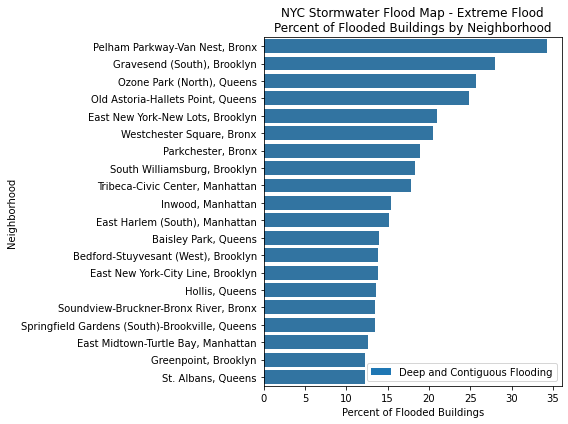

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Deep and Contiguous Flooding'

data = (
    merged_gdf
    .sort_values(by='flooded_perc', ascending=False)
    .loc[:, ['ntaname_boro', 'building_count', 'flooded_count', 'flooded_perc']]
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Buildings by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

**Figure xx**:

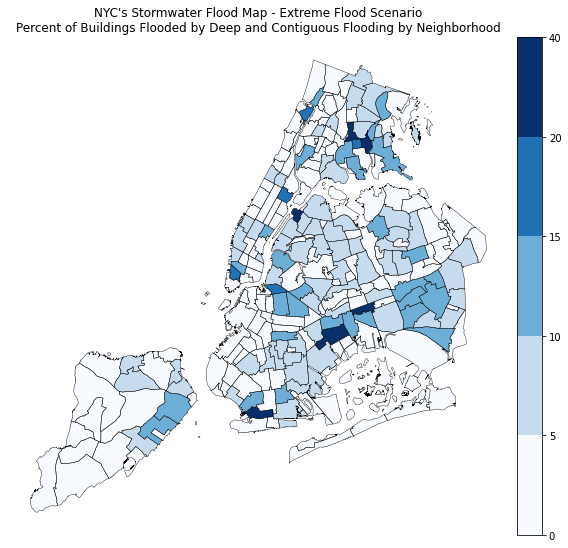

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 5, 10, 15, 20, 40], cmap.N)

merged_gdf.plot(
    column='flooded_perc',
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
sup_title = 'Percent of Buildings Flooded by Deep and Contiguous Flooding by Neighborhood'
ax.set_title('{}\n{}'.format(title, sup_title))

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/deep-flood-buildings-perc.png', dpi=250, bbox_inches='tight')

**Figure xx:**

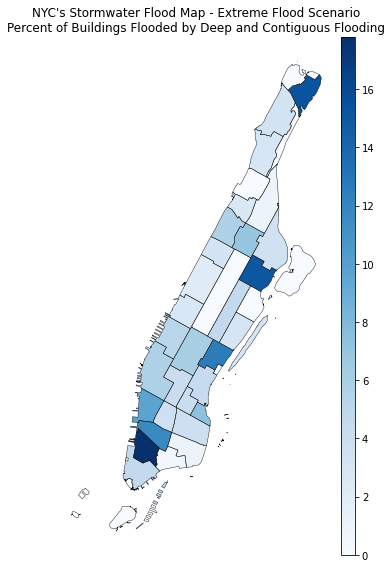

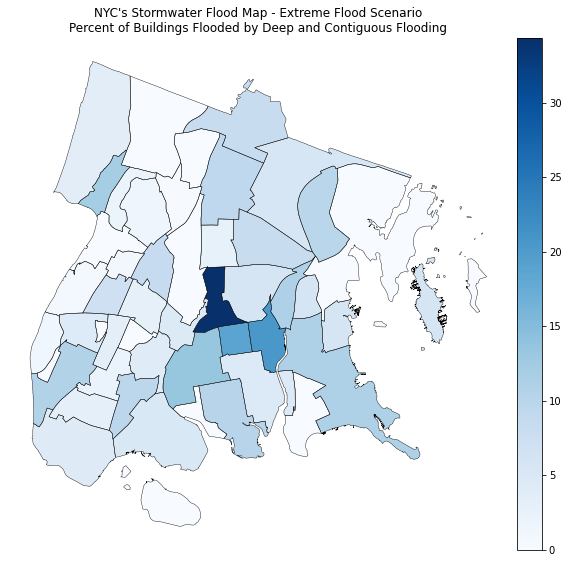

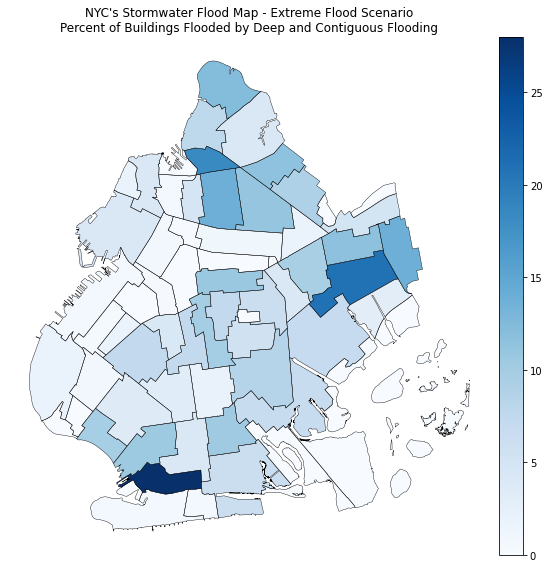

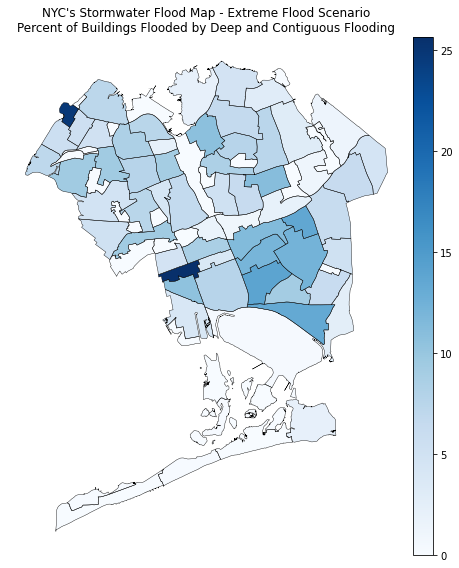

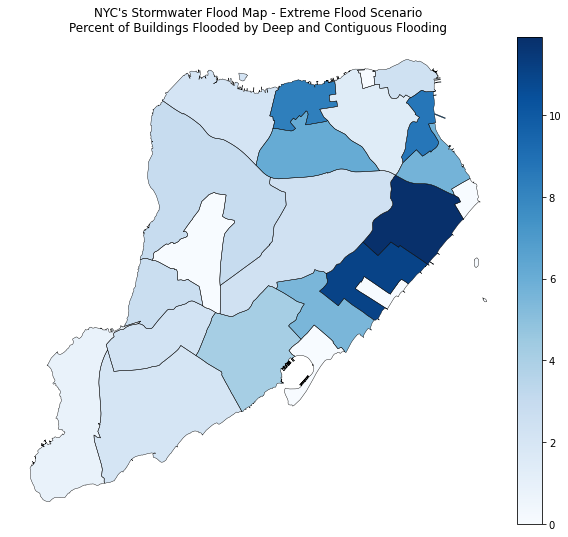

In [15]:
boros = merged_gdf['boroname'].unique()

for boro in boros: 
    fig, ax = plt.subplots(figsize=(8, 8))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cmap = plt.cm.Blues

    (merged_gdf
     .loc[merged_gdf['boroname'] == boro]
     .plot(
        column='flooded_perc',
        legend=True,
        cmap=cmap,
        ax=ax,
        cax=cax)
    )

    (nta_gdf
     .loc[nta_gdf['boroname'] == boro]
     .plot(
        ax=ax,
        zorder=1,
        facecolor='None',
        linewidth=.4)
    )

    title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
    sup_title = 'Percent of Buildings Flooded by Deep and Contiguous Flooding'
    ax.set_title('{}\n{}'.format(title, sup_title))
    
    ax.axis('off')
    plt.tight_layout()

### Percent of Buildings Flooded: Future High Tides 2080

In [16]:
cols = ['nta2020', 'ntaname_boro', 'building_count', 'flood_classification', 'flooded_count', 'flooded_perc']
classification = 'Future High Tides 2080'

merged_gdf = nta_gdf.merge(
    df.loc[df['flood_classification'] == classification, cols],
    on='nta2020',
    how='left'
)

cols = ['building_count', 'flooded_count', 'flooded_perc']
for col in cols:
    merged_gdf[col] = merged_gdf[col].fillna(0)

print('shape of data: {}'.format(merged_gdf.shape))
merged_gdf.head()

shape of data: (262, 17)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,building_count,flood_classification,flooded_count,flooded_perc
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23...",NaN,0.0,NaN,0.0,0.00
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21...","Chelsea-Hudson Yards, Manhattan",2092.0,Future High Tides 2080,72.0,3.44
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19...","Chinatown-Two Bridges, Manhattan",1126.0,Future High Tides 2080,8.0,0.71
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436...","East Harlem (North), Manhattan",2002.0,Future High Tides 2080,10.0,0.50
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ...","East Harlem (South), Manhattan",1033.0,Future High Tides 2080,4.0,0.39


In [17]:
(merged_gdf
 .sort_values(by='flooded_perc', ascending=False)
 .loc[:, ['ntaname_boro', 'building_count', 'flooded_count', 'flooded_perc']]
 .astype({'building_count':'int', 'flooded_count':'int'})
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,building_count,flooded_count,flooded_perc
0,"Rockaway Beach-Arverne-Edgemere, Queens",4454,3406,76.47
1,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,9424,6124,64.98
2,"Coney Island-Sea Gate, Brooklyn",3358,1162,34.60
3,"Howard Beach-Lindenwood, Queens",6870,2064,30.04
4,"Brighton Beach, Brooklyn",2072,620,29.92
5,"Far Rockaway-Bayswater, Queens",6786,1817,26.78
6,"Financial District-Battery Park City, Manhattan",635,170,26.77
7,"Stuyvesant Town-Peter Cooper Village, Manhattan",81,18,22.22
8,"Jacob Riis Park-Fort Tilden-Breezy Point Tip, ...",164,31,18.90
9,Sheepshead Bay-Manhattan Beach-Gerritsen Beach...,11282,1857,16.46


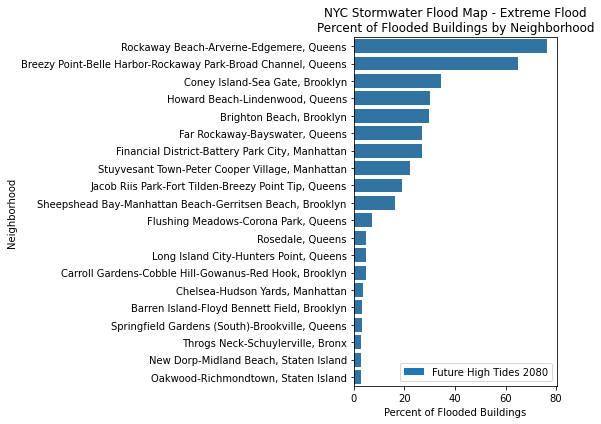

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Future High Tides 2080'

data = (
    merged_gdf
    .sort_values(by='flooded_perc', ascending=False)
    .loc[:, ['ntaname_boro', 'building_count', 'flooded_count', 'flooded_perc']]
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Buildings by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

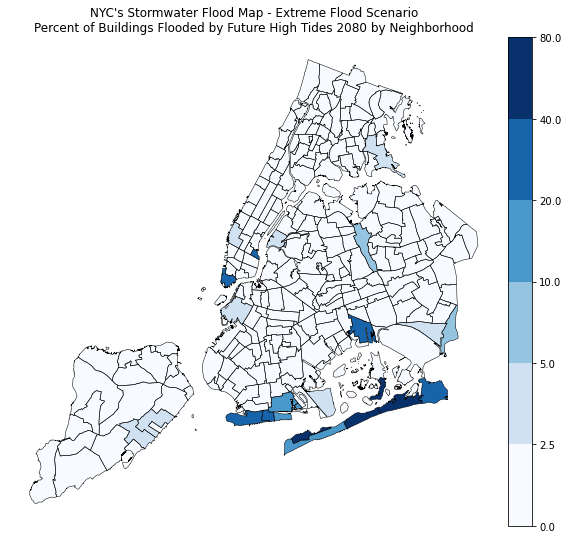

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 2.5, 5, 10, 20, 40, 80], cmap.N)

merged_gdf.plot(
    column='flooded_perc',
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.5,
)

title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
sup_title = 'Percent of Buildings Flooded by Future High Tides 2080 by Neighborhood'
ax.set_title('{}\n{}'.format(title, sup_title))

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/high-tide-buildings-perc.png', dpi=250, bbox_inches='tight')

**Figure xx**:

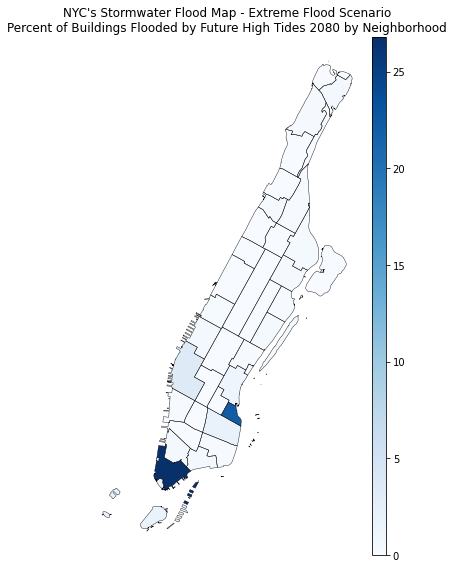

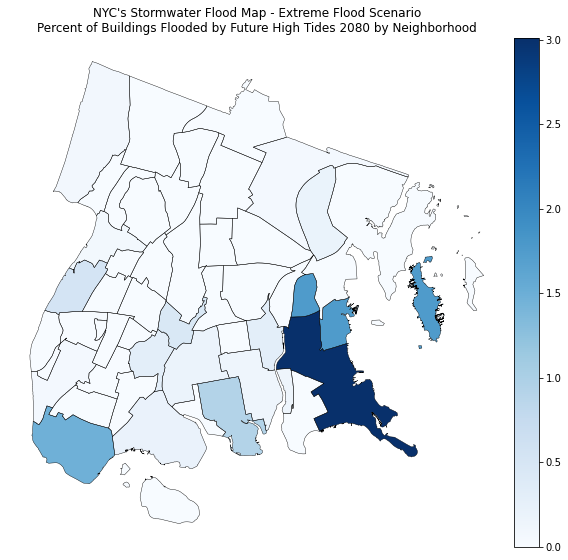

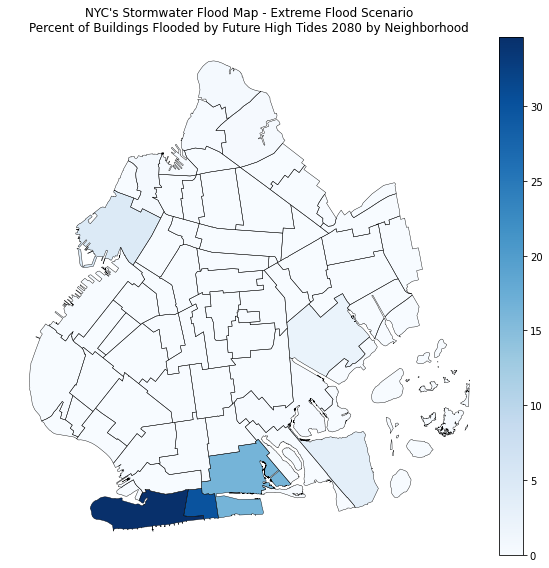

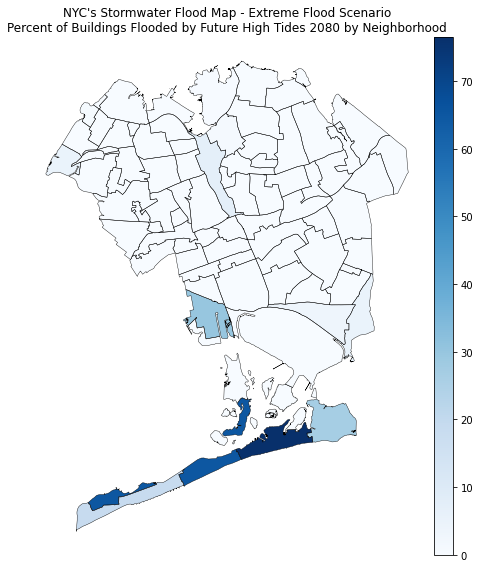

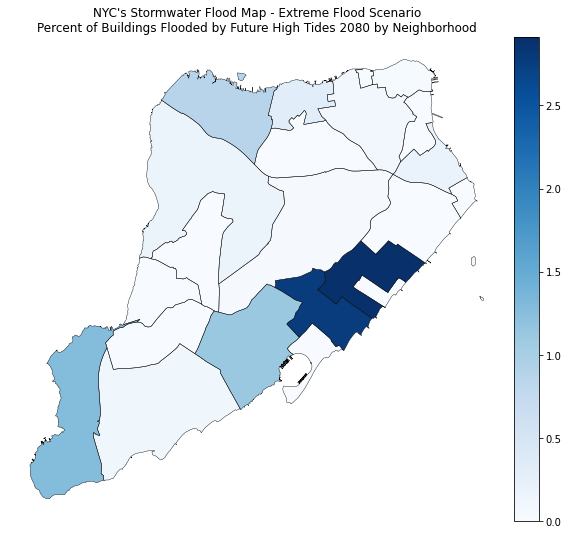

In [20]:
boros = merged_gdf['boroname'].unique()

for boro in boros: 
    fig, ax = plt.subplots(figsize=(8, 8))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cmap = plt.cm.Blues

    (merged_gdf
     .loc[merged_gdf['boroname'] == boro]
     .plot(
        column='flooded_perc',
        legend=True,
        cmap=cmap,
        ax=ax,
        cax=cax)
    )

    (nta_gdf
     .loc[nta_gdf['boroname'] == boro]
     .plot(
        ax=ax,
        zorder=1,
        facecolor='None',
        linewidth=.4)
    )
    
    title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
    sup_title = 'Percent of Buildings Flooded by Future High Tides 2080 by Neighborhood'
    ax.set_title('{}\n{}'.format(title, sup_title))
    
    ax.axis('off')
    plt.tight_layout()

**Figure xx**:

## Percent of Area Flooded

In [21]:
ls data/

buildings-hazard.csv      hourly-precipitation.csv  stormwater-data-source/
daily-precipitation.csv   nta-hazard.csv            stormwater-data.zip


In [22]:
# percent of area flooded by neigborhood
path = 'data/nta-hazard.csv'
df = pd.read_csv(path)

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (620, 8)


,nta2020,shape_area,flood_classification,flooded_area,flooded_area_perc,ntaname,boroname,ntaname_boro
0,BK0101,3.532121e+07,Deep and Contiguous Flooding,1.790620e+06,5.07,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
1,BK0101,3.532121e+07,Future High Tides 2080,2.038655e+06,5.77,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
2,BK0101,3.532121e+07,Nuisance Flooding,1.307740e+06,3.70,Greenpoint,Brooklyn,"Greenpoint, Brooklyn"
3,BK0102,2.885436e+07,Deep and Contiguous Flooding,1.706097e+06,5.91,Williamsburg,Brooklyn,"Williamsburg, Brooklyn"
4,BK0102,2.885436e+07,Future High Tides 2080,7.384257e+05,2.56,Williamsburg,Brooklyn,"Williamsburg, Brooklyn"


In [23]:
# summary statistics of percent of area flooded by neigborhood
(df
 .groupby(by='flood_classification')['flooded_area_perc']
 .describe()
)

,count,mean,std,min,25%,50%,75%,max
flood_classification,,,,,,,,
Deep and Contiguous Flooding,240.0,3.284000,2.737847,0.01,1.1325,2.460,5.1825,14.30
Future High Tides 2080,132.0,5.445758,9.065596,0.00,0.5550,1.895,5.4325,56.21
Nuisance Flooding,248.0,3.565484,2.510365,0.02,1.6100,3.285,5.1100,11.47


### Percent of Area Flooded: Deep and Contiguous Flooding

In [24]:
cols = ['nta2020', 'ntaname_boro', 'flood_classification', 'flooded_area', 'flooded_area_perc']
classification = 'Deep and Contiguous Flooding'

merged_gdf = nta_gdf.merge(
    df.loc[df['flood_classification'] == classification, cols],
    on='nta2020',
    how='left'
)

cols = ['shape_area', 'flooded_area', 'flooded_area_perc']
for col in cols:
    merged_gdf[col] = merged_gdf[col].fillna(0)

print('shape of data: {}'.format(merged_gdf.shape))
merged_gdf.head()

shape of data: (262, 16)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,flood_classification,flooded_area,flooded_area_perc
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23...",NaN,NaN,0.000000,0.00
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21...","Chelsea-Hudson Yards, Manhattan",Deep and Contiguous Flooding,625930.867140,2.11
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19...","Chinatown-Two Bridges, Manhattan",Deep and Contiguous Flooding,77539.916379,0.67
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436...","East Harlem (North), Manhattan",Deep and Contiguous Flooding,371509.986399,1.42
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ...","East Harlem (South), Manhattan",Deep and Contiguous Flooding,622475.411398,3.74


In [25]:
(merged_gdf
 .sort_values(by='flooded_area_perc', ascending=False)
 .loc[:, ['ntaname_boro', 'shape_area', 'flooded_area', 'flooded_area_perc']]
 .set_index('ntaname_boro')
 .div({'shape_area':43560, 'flooded_area':43560, 'flooded_area_perc':1})
 .astype({'shape_area':int, 'flooded_area':int})
 .rename(columns={'shape_area':'shape_area_acre', 'flooded_area':'flooded_area_acre'})
 .head(20)
 .reset_index(drop=False)
)

,ntaname_boro,shape_area_acre,flooded_area_acre,flooded_area_perc
0,"South Williamsburg, Brooklyn",349,49,14.30
1,"Gravesend (South), Brooklyn",593,78,13.17
2,"Ozone Park (North), Queens",415,50,12.17
3,"Fresh Meadows-Utopia, Queens",762,80,10.57
4,"East New York-New Lots, Brooklyn",1066,104,9.83
5,"South Jamaica, Queens",869,83,9.59
6,"Hollis, Queens",561,53,9.48
7,"Corona, Queens",551,50,9.21
8,"Old Astoria-Hallets Point, Queens",254,23,9.16
9,"Tribeca-Civic Center, Manhattan",311,27,8.98


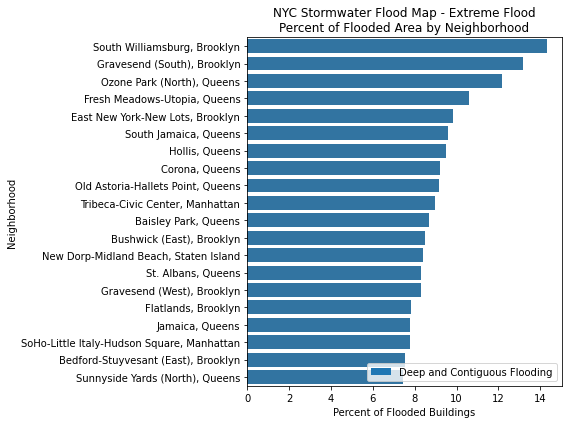

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Deep and Contiguous Flooding'

data = (
    merged_gdf
    .sort_values(by='flooded_area_perc', ascending=False)
    .loc[:, ['ntaname_boro', 'flooded_area', 'flooded_area_perc']]
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_area_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Area by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

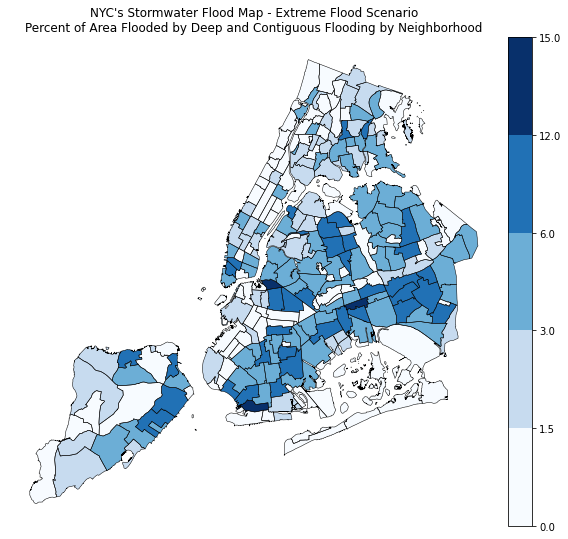

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 1.5, 3, 6, 12, 15], cmap.N)

merged_gdf.plot(
    column='flooded_area_perc',
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax, cax=cax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.5,
)

title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
sup_title = 'Percent of Area Flooded by Deep and Contiguous Flooding by Neighborhood'
ax.set_title('{}\n{}'.format(title, sup_title))

ax.axis('off')
plt.tight_layout()

**Figure xx**:

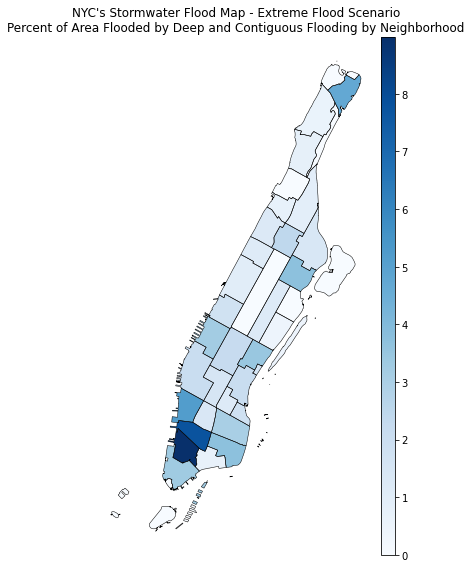

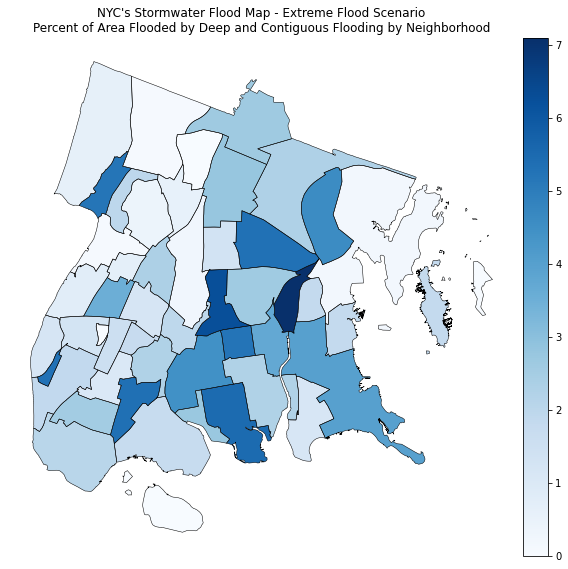

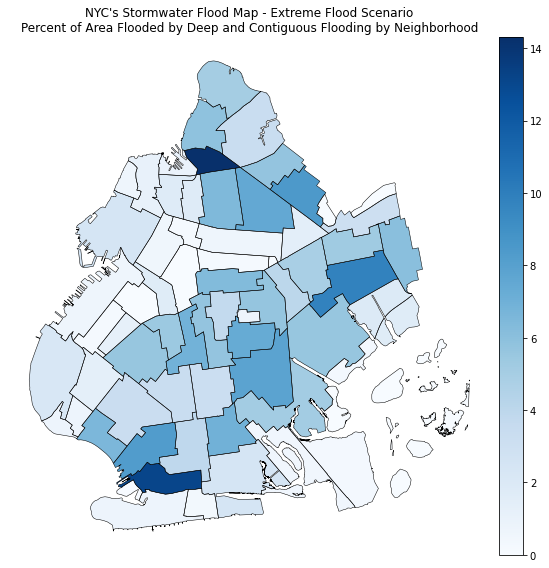

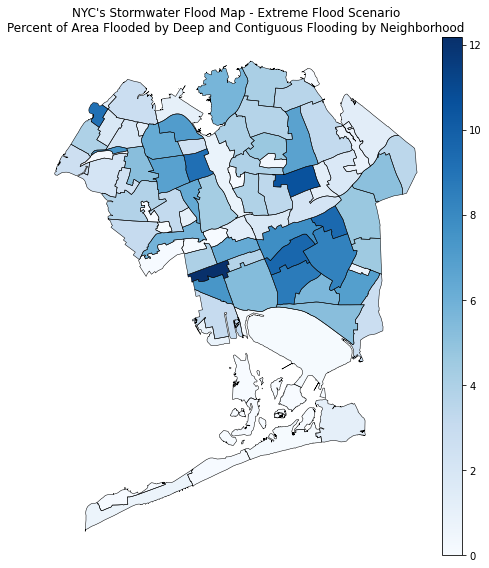

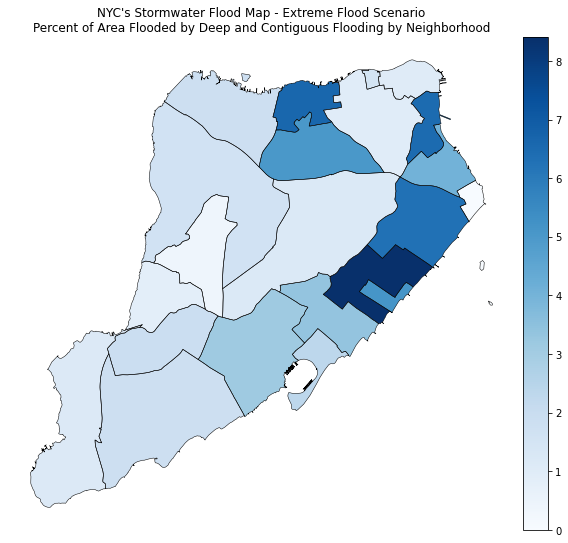

In [28]:
boros = merged_gdf['boroname'].unique()

for boro in boros: 
    
    fig, ax = plt.subplots(figsize=(8, 8))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cmap = plt.cm.Blues

    (merged_gdf
     .loc[merged_gdf['boroname'] == boro]
     .plot(
        column='flooded_area_perc',
        legend=True,
        cmap=cmap,
        ax=ax, cax=cax)
    )

    (nta_gdf
     .loc[nta_gdf['boroname'] == boro]
     .plot(
        ax=ax,
        zorder=1,
        facecolor='None',
        linewidth=.5)
    )

    title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
    sup_title = 'Percent of Area Flooded by Deep and Contiguous Flooding by Neighborhood'
    ax.set_title('{}\n{}'.format(title, sup_title))
    
    ax.axis('off')
    plt.tight_layout()

**Figure xx**:

### Percent of Area Flooded: Future High Tides 2080

In [29]:
cols = ['nta2020', 'ntaname_boro', 'flood_classification', 'flooded_area', 'flooded_area_perc']
classification = 'Future High Tides 2080'

merged_gdf = nta_gdf.merge(
    df.loc[df['flood_classification'] == classification, cols],
    on='nta2020',
    how='left'
)

cols = ['flooded_area', 'flooded_area_perc']
for col in cols:
    merged_gdf[col] = merged_gdf[col].fillna(0)

print('shape of data: {}'.format(merged_gdf.shape))
merged_gdf.head()

shape of data: (262, 16)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro,flood_classification,flooded_area,flooded_area_perc
0,1.0,Manhattan,061,MN6491,Central Park,CntrlPk,9,MN64,MN64 Central Park (JIA 64 Equivalent),32721.097429,3.831238e+07,"POLYGON ((997412.248 230101.816, 997436.269 23...",NaN,NaN,0.000000e+00,0.00
1,1.0,Manhattan,061,MN0401,Chelsea-Hudson Yards,Chls_HdsYd,0,MN04,MN04 Chelsea-Hell's Kitchen (CD 4 Approximation),40095.235570,2.967175e+07,"POLYGON ((983031.177 217138.506, 983640.320 21...","Chelsea-Hudson Yards, Manhattan",Future High Tides 2080,3.141988e+06,10.59
2,1.0,Manhattan,061,MN0301,Chinatown-Two Bridges,Chntwn,0,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),16464.371337,1.154263e+07,"POLYGON ((987256.457 200392.989, 987090.306 19...","Chinatown-Two Bridges, Manhattan",Future High Tides 2080,6.174623e+05,5.35
3,1.0,Manhattan,061,MN1102,East Harlem (North),EstHrlm_N,0,MN11,MN11 East Harlem (CD 11 Equivalent),28710.999462,2.610451e+07,"MULTIPOLYGON (((1004410.678 229781.419, 100436...","East Harlem (North), Manhattan",Future High Tides 2080,1.304307e+06,5.00
4,1.0,Manhattan,061,MN1101,East Harlem (South),EstHrlm_S,0,MN11,MN11 East Harlem (CD 11 Equivalent),18682.264948,1.665394e+07,"POLYGON ((1000577.175 228028.553, 1001238.138 ...","East Harlem (South), Manhattan",Future High Tides 2080,3.208221e+05,1.93


In [30]:
(merged_gdf
 .sort_values(by='flooded_area_perc', ascending=False)
 .loc[:, ['ntaname_boro', 'shape_area', 'flooded_area', 'flooded_area_perc']]
 .set_index('ntaname_boro')
 .div({'shape_area':43560, 'flooded_area':43560, 'flooded_area_perc':1})
 .astype({'shape_area':int, 'flooded_area':int})
 .rename(columns={'shape_area':'shape_area_acre', 'flooded_area':'flooded_area_acre'})
 .head(20)
 .reset_index(drop=False)
)

,ntaname_boro,shape_area_acre,flooded_area_acre,flooded_area_perc
0,"Rockaway Beach-Arverne-Edgemere, Queens",1159,651,56.21
1,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,1589,792,49.88
2,"Coney Island-Sea Gate, Brooklyn",1090,416,38.21
3,"Jacob Riis Park-Fort Tilden-Breezy Point Tip, ...",1208,328,27.18
4,"Far Rockaway-Bayswater, Queens",1388,368,26.51
5,"Rockaway Community Park, Queens",204,53,25.93
6,"Howard Beach-Lindenwood, Queens",1207,300,24.92
7,"Brighton Beach, Brooklyn",311,72,23.26
8,"Rosedale, Queens",1084,202,18.66
9,"Jamaica Bay (East), Queens",1605,293,18.27


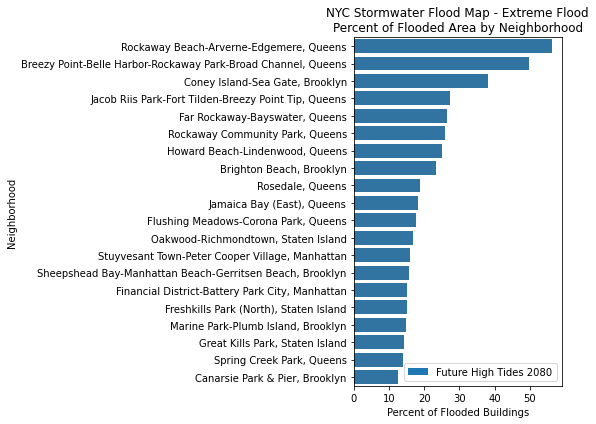

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

label = 'Future High Tides 2080'

data = (
    merged_gdf
    .sort_values(by='flooded_area_perc', ascending=False)
    .loc[:, ['ntaname_boro', 'flooded_area', 'flooded_area_perc']]
    .head(20)
)

sns.barplot(
    data=data, 
    y='ntaname_boro', 
    x='flooded_area_perc', 
    color='C0',
    ax=ax
)

patches = [mpatches.Patch(label=label)]
plt.legend(handles=patches, loc=4, fontsize=10)

plt.title('NYC Stormwater Flood Map - Extreme Flood\n\
Percent of Flooded Area by Neighborhood', fontsize=12)
plt.xlabel('Percent of Flooded Buildings')
plt.ylabel('Neighborhood')
plt.tight_layout()

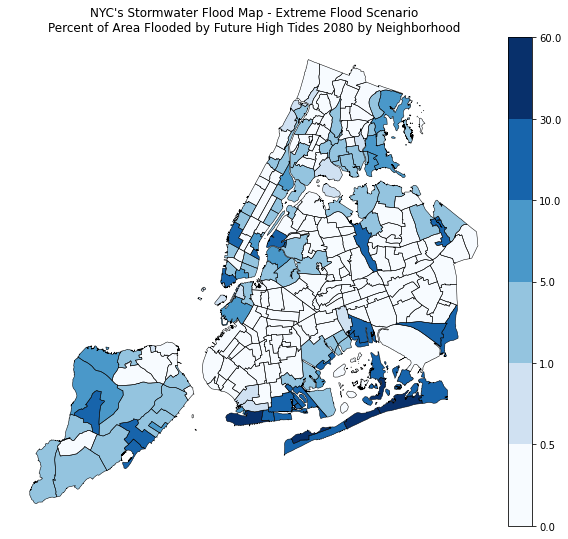

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, .5, 1, 5, 10, 30, 60], cmap.N)

merged_gdf.plot(
    column='flooded_area_perc',
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax, cax=cax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.5,
)

title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
sup_title = 'Percent of Area Flooded by Future High Tides 2080 by Neighborhood'
ax.set_title('{}\n{}'.format(title, sup_title))

ax.axis('off')
plt.tight_layout()

**Figure xx**:

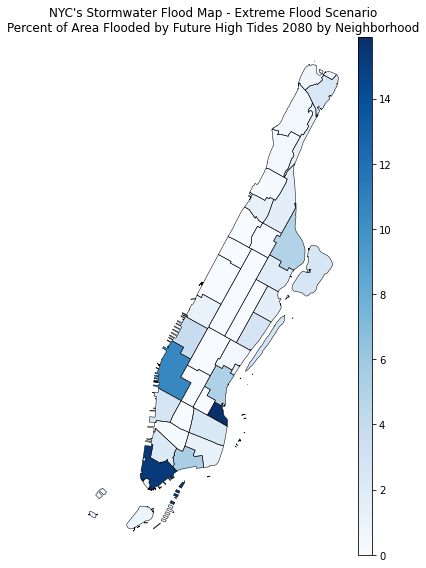

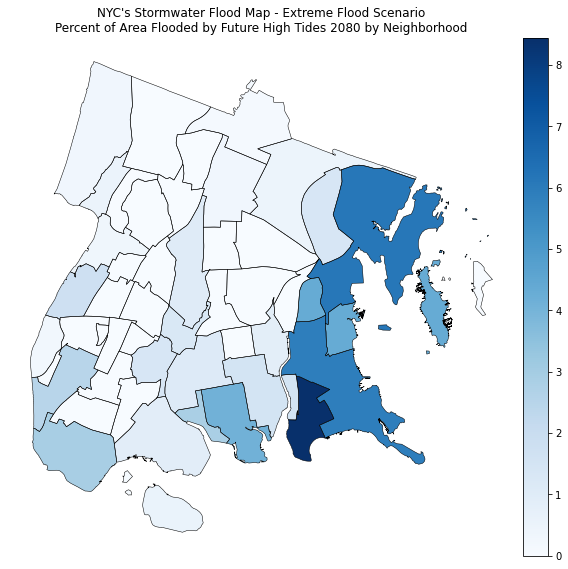

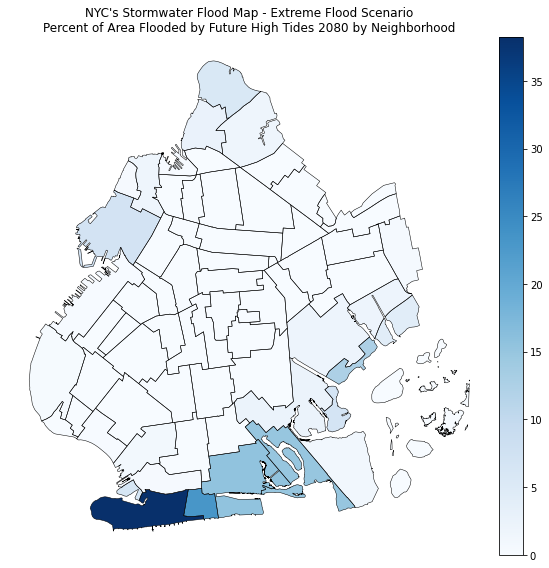

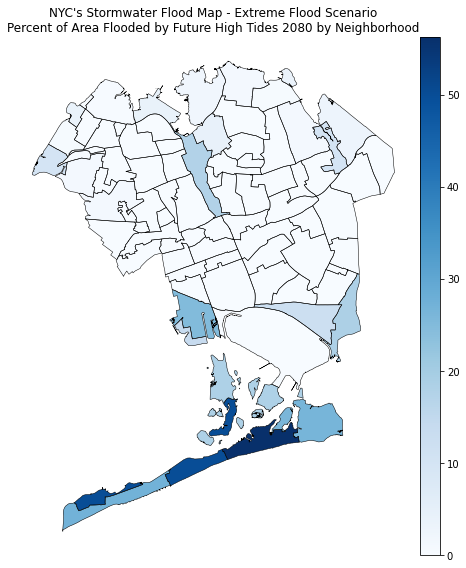

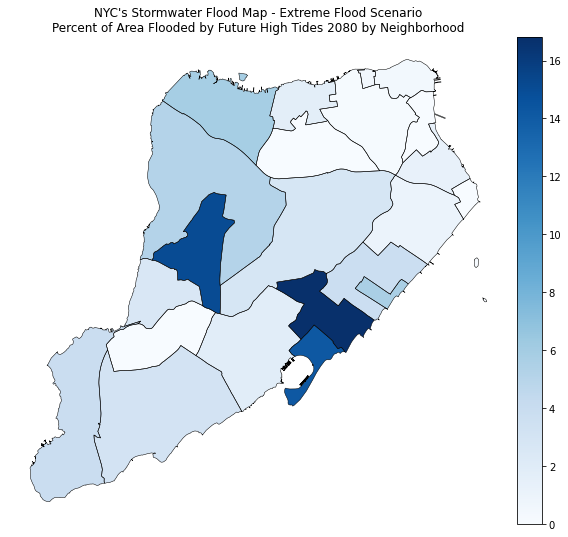

In [33]:
boros = merged_gdf['boroname'].unique()

for boro in boros: 
    
    fig, ax = plt.subplots(figsize=(8, 8))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cmap = plt.cm.Blues

    (merged_gdf
     .loc[merged_gdf['boroname'] == boro]
     .plot(
        column='flooded_area_perc',
        legend=True,
        cmap=cmap,
        ax=ax, cax=cax)
    )

    (nta_gdf
     .loc[nta_gdf['boroname'] == boro]
     .plot(
        ax=ax,
        zorder=1,
        facecolor='None',
        linewidth=.5)
    )

    title = "NYC's Stormwater Flood Map - Extreme Flood Scenario"
    sup_title = 'Percent of Area Flooded by Future High Tides 2080 by Neighborhood'    
    ax.set_title('{}\n{}'.format(title, sup_title))
    
    ax.axis('off')
    plt.tight_layout()

**Figure xx**:

# Precipitation Analysis

## Hourly Precipitation Data

###  ASOS Data Download from Iowa Environmental Mesonet (IEM)

Source: https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#

![iem-cover-photo](images/iem-cover-photo.png)

Screenshot of ASOS Data Download.  

![asos-data-dictionary](images/asos-data-dictionary.png)

Screenshot of ASOS Data Dictionary.

In [34]:
path = 'data/hourly-precipitation.csv'

df = pd.read_csv(path)
print('shape of data: {}'.format(df.shape))
df['datetime'] = pd.to_datetime(df['datetime'])

# preview data
df.head()

shape of data: (303920, 7)


,station,valid,datetime,lon,lat,p01mm,p01in
0,NYC,1965-01-02 18:00,1965-01-02 18:00:00,-73.9693,40.779,0.51,0.0201
1,NYC,1965-01-02 21:00,1965-01-02 21:00:00,-73.9693,40.779,1.27,0.0500
2,NYC,1965-01-03 00:00,1965-01-03 00:00:00,-73.9693,40.779,1.27,0.0500
3,NYC,1965-01-03 03:00,1965-01-03 03:00:00,-73.9693,40.779,NaN,NaN
4,NYC,1965-01-03 06:00,1965-01-03 06:00:00,-73.9693,40.779,NaN,NaN


In [35]:
# review column nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303920 entries, 0 to 303919
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   station   303920 non-null  object        
 1   valid     303920 non-null  object        
 2   datetime  303920 non-null  datetime64[ns]
 3   lon       303920 non-null  float64       
 4   lat       303920 non-null  float64       
 5   p01mm     112502 non-null  float64       
 6   p01in     112502 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 16.2+ MB


In [36]:
print('datetime bounds of analysis:\n')
print('date min: {}'.format(df['datetime'].min()))
print('date max: {}'.format(df['datetime'].max()))

datetime bounds of analysis:

date min: 1965-01-02 18:00:00
date max: 2023-10-08 23:51:00


### Analysis of extreme rainfall

>The standard design criterion in New York City is to use the
>intensity-duration values based on a storm with a 5-year return
>period (e.g., 1.75 inches per hour for a one hour storm; 20 percent
>chance of occurrence in any given year) to calculate how large the
>sewer pipes need to be sized to appropriately manage stormwater.
>Certain older areas of the City are designed to a 3-year storm
>event. The sewer design flow is then determined by application
>of an equation using a runoff coefficient, a rainfall intensity
>determined from an equation derived from the IDF analysis, and
>the contributory drainage area. The design of combined sewers
>includes allowance for the sanitary flows. The IDF curve currently
>used by New York City is based on historical data from 1903-1951.
>With climate change, the intensity and duration of a storm with a
>5-year return period is likely to increase, and therefore the current
>curve may not be adequate for designing infrastructure that is to
>last decades.

Source: https://www.nyc.gov/assets/orr/pdf/publications/stormwater-resiliency-plan.pdf

In [37]:
counts = df.loc[df['p01in'] >= 1.75].shape[0]

print('Number of hourly observations with >= 1.75 inches of precipitation: {}'.format(counts))

Number of hourly observations with >= 1.75 inches of precipitation: 4


In [38]:
# records in print view
records = (
    df
    .loc[df['p01in'] >= 1.75, ['valid', 'p01in']]
    .rename(columns={'valid':'date', 'p01in':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
)

print(records)

                  inches
date                    
2021-09-02 01:51  3.1500
2023-09-29 13:51  1.9598
2021-08-22 03:51  1.9402
2004-09-08 11:51  1.7598


**Table xx:** Top precipitation events of over 1.75 inches of rainfall per hour at Central Park, NYC.

In [39]:
# top 20 hourly precipitation events
records = (
    df
    .loc[:, ['valid', 'p01in']]
    .rename(columns={'valid':'date', 'p01in':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
    .head(20)
)

print(records)

                  inches
date                    
2021-09-02 01:51  3.1500
2023-09-29 13:51  1.9598
2021-08-22 03:51  1.9402
2004-09-08 11:51  1.7598
2005-08-14 23:51  1.7000
2007-08-08 10:51  1.7000
2018-08-11 12:51  1.6598
2020-08-12 20:51  1.6299
1967-07-03 09:00  1.5799
2006-08-10 23:51  1.5701
2021-07-08 21:51  1.5598
1973-08-02 15:00  1.5098
2021-09-02 02:51  1.5000
2010-10-01 09:51  1.4799
2009-01-17 16:51  1.4299
2009-01-17 23:51  1.4098
2021-08-22 02:51  1.3799
2021-07-12 06:51  1.3500
2022-12-23 09:51  1.3299
2009-01-17 21:51  1.3299


**Table xx:** Top 20 precipitation events per hour at Central Park, NYC.

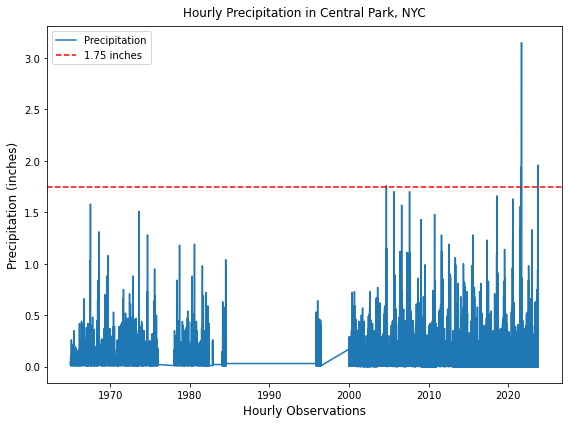

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=df['datetime'],
    y=df['p01in'],
    label='Precipitation'
)

plt.title(
    'Hourly Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r',linestyle='--', label='1.75 inches')

plt.legend(loc=2)
plt.xlabel('Hourly Observations', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

**Figure xx:** The figure above looks a bit weird with big chunks of missing data. This is only to demonstrate the distribution of values and extreme values. There is a big gap in the hourly data from 1985 to 2000.

## Daily Precipitation Data

I used NOAA's NCEI Climate Data Online Daily Summaries.

### NCEI Climate Data Online's Daily Summaries, NY CITY CENTRAL PARK, NY US

Source: https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

![ncei-daily-summaries](images/ncei-daily-summaries.png)

Screenshot of NCEI Climate Data Online's Daily Summaries.

In [41]:
# download of data was performed manually by me from NCEI above
df = pd.read_csv('data/daily-precipitation.csv')

## to datetime
df['datetime'] = pd.to_datetime(df['DATE'])

# preview data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (56535, 9)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,datetime
0,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-01,0.75,",,Z,",1869-01-01
1,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-02,0.03,",,Z,null",1869-01-02
2,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-03,0.00,"T,,Z,null",1869-01-03
3,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-04,0.18,",,Z,null",1869-01-04
4,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,1869-01-05,0.05,",,Z,null",1869-01-05


In [42]:
print('datetime bounds of analysis:\n')
print('date min: {}'.format(df['datetime'].min()))
print('date max: {}'.format(df['datetime'].max()))

datetime bounds of analysis:

date min: 1869-01-01 00:00:00
date max: 2023-10-15 00:00:00


### The number of days with extreme rainfall

>Recent academic studies show that sub-daily rainfall intensity
>may increase over the coming decades.<sup>5</sup> Since rainfall information
>started being collected, the number of days with extreme rainfall
>(defined as days of rainfall over 1.75 inches in Central Park) has
>increased.<sup>6</sup>

Source: https://www.nyc.gov/assets/orr/pdf/publications/stormwater-resiliency-plan.pdf

In [43]:
counts = df.loc[df['PRCP'] >= 1.75].shape[0]

print('Total number of daily observations with >= 1.75 inches of precipitation: {}'.format(counts))

Total number of daily observations with >= 1.75 inches of precipitation: 545


In [44]:
# top 20 daily precipitation events
records = (
    df
    .loc[:, ['datetime', 'PRCP']]
    .rename(columns={'datetime':'date', 'PRCP':'inches'})
    .sort_values(by='inches', ascending=False)
    .set_index('date')
    .head(20)
)

print(records)

            inches
date              
1882-09-23    8.28
2007-04-15    7.57
1977-11-08    7.40
1903-10-09    7.33
2021-09-01    7.13
2011-08-14    5.81
1972-11-08    5.60
1966-09-21    5.54
2023-09-29    5.48
1999-09-16    5.02
1913-10-01    4.98
2014-04-30    4.97
1934-09-08    4.86
1909-08-16    4.80
1873-08-20    4.80
1990-08-10    4.64
2021-08-21    4.45
1996-10-19    4.35
1983-04-10    4.31
1903-10-08    4.30


**Table xx:** Top precipitation events per day at Central Park, NYC.

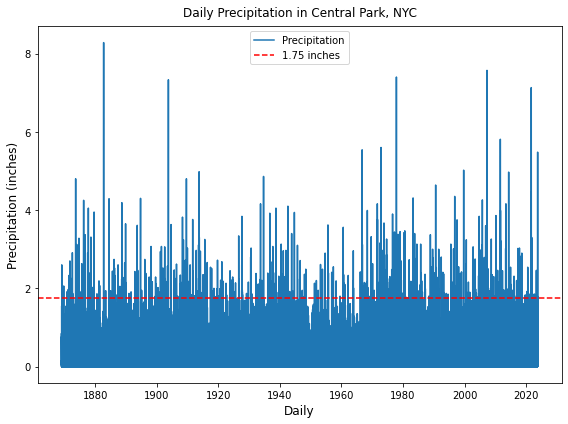

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=df.set_index('datetime').index,
    y=df['PRCP'],
    label='Precipitation'
)

plt.title(
    'Daily Precipitation in Central Park, NYC', 
    fontsize=12,
    pad=10
)

plt.axhline(y=1.75, color='r', linestyle='--', label='1.75 inches')

plt.legend(loc='upper center')
plt.xlabel('Daily', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.tight_layout()

**Figure xx:** Daily Precipitation in Central Park, NYC.

In [46]:
# assign flag to extreme days
df.loc[df['PRCP'] >= 1.75, ['threshold']] = 1

# count days and bin data by decade
bins = [x for x in range(1860, 2040, 10)]
df['bins'] = pd.cut(df['datetime'].dt.year, bins=bins)

data = (
    df
    .groupby(by='bins')['threshold']
    .sum()
    .astype(int)
    .rename('count')
    .reset_index()
)

# clipping incomplete decades, remove from plot
data = data.iloc[1:-1, :]
data

,bins,count
1,"(1870, 1880]",33
2,"(1880, 1890]",30
3,"(1890, 1900]",26
4,"(1900, 1910]",41
5,"(1910, 1920]",36
6,"(1920, 1930]",27
7,"(1930, 1940]",32
8,"(1940, 1950]",21
9,"(1950, 1960]",22
10,"(1960, 1970]",25


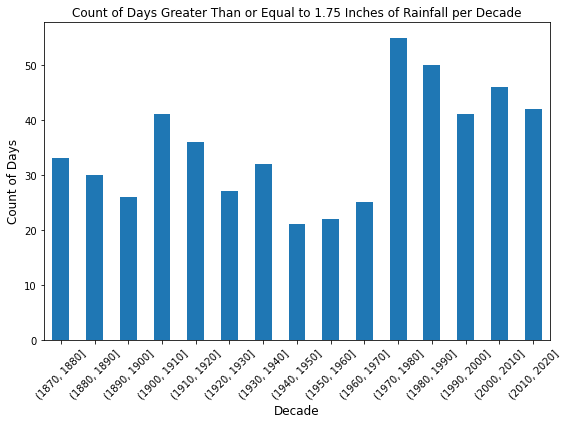

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

data.plot.bar(
    x='bins',
    y='count',
    rot=45,
    legend=None,
    ax=ax 
)

plt.title('Count of Days Greater Than or Equal to 1.75 Inches of Rainfall per Decade', fontsize=12)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Count of Days', fontsize=12)
plt.tight_layout()
plt.savefig('figures/precip-cover-photo.png', dpi=250, bbox_inches='tight')

**Figure xx:** Count of days greater than or equal to 1.75 inches of rainfall per decade.

## NOAA ATLAS 14 Point Precipitation Frequency Estimates

>NOAA Atlas 14 estimates are used to design, plan, and manage
>much of the Nation's infrastructure for a wide variety of purposes
>under federal, state, and local regulations. NOAA Atlas 14
>estimates replace estimates previously published by NOAA in
>the early 1960s and '70s and cover a range of storm durations
>from 5-minutes through 60-days, for average recurrence intervals
>of 1-year through 1,000-year. Compared to previous volumes,
>Atlas 14 estimates benefit from use of better-quality data (e.g.
>precipitation stations with longer period of record, increased
>station density, etc.), enhanced quality control methods,
>consideration of uncertainties, and improved frequency analysis
>and spatial interpolation methods that account for variation in
>terrain, proximity to the coastline etc.

Source: https://www.weather.gov/owp/hdsc

Atlas 14 is so influencial with the country's design standards, I figured I would add a section about it. The first set of screen shots are from NOAA's Atlas 14, and the last one is the flood scenarios from the NYC Stormwater Flood Maps. It's good to understand and communicate the relationship between duration (e.g. 60-min), average reoccurance interval (e.g. 100-year), precipitation levels and potential flood depths.

### Station Name: NY CITY CNTRL PARK
Below are screenshots and data for Central Park, NYC.

![atlas-14-cover](images/atlas-14-cover.png)

Screenshot of the landing page.  
Source: https://hdsc.nws.noaa.gov/pfds/pfds_map_cont.html?bkmrk=ny

![frequency-table](images/frequency-table.png)

Table caption from NOAA:  
>Precipitation frequency (PF) estimates in this table are based on frequency analysis of partial duration 
>series (PDS). Numbers in parenthesis are PF estimates at lower and upper bounds of the 90% confidence interval.
>The probability that precipitation frequency estimates (for a given duration and average recurrence interval)
>will be greater than the upper bound (or less than the lower bound) is 5%.
>Estimates at upper bounds are not checked against probable maximum precipitation (PMP) estimates and may be higher than currently valid PMP  values. Please refer to NOAA Atlas 14 document for more information.

Source: https://hdsc.nws.noaa.gov/pfds/pfds_printpage.html?st=ny&sta=30-5801&data=depth&units=english&series=pds

![ddf-curves](images/ddf-curves.png)

Source: https://hdsc.nws.noaa.gov/pfds/pfds_printpage.html?st=ny&sta=30-5801&data=depth&units=english&series=pds

The flood scenarios for the NYC Stormwater Flood Maps are below. Things to note: extreme scenario consists of `Deep and Continous Flooding` depths of 1 ft. and greater, and `Sea Level Rise` heights of + 4.8 ft.

![iem-cover-photo](images/flood-scenarios.png)
  
Source: https://experience.arcgis.com/experience/6f4cc60710dc433585790cd2b4b5dd0e